In [26]:
import torch
from torchvision import models
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os
import time
import graphviz
import seaborn
from torchview import draw_graph
from matplotlib import pyplot as plt

graphviz.set_jupyter_format('png')
%matplotlib inline

# 1. Загрузка данных

In [27]:
dir_name = os.getcwd()

In [28]:
def get_datasets(transform):
  train_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = True, download = True,
      transform = transform
  )
  test_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = False, download = True,
      transform = transform
  )
  return train_dataset, test_dataset

# 2. Построение архитектуры сверточной сети

Параметры:

In [29]:
learning_rate = 0.001
num_epochs = 10
batch_size = 512

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.CrossEntropyLoss()

In [31]:
device

device(type='cuda')

In [32]:
def get_loaders(train_dataset, test_dataset):
  train_data_loader = torch.utils.data.DataLoader(
      train_dataset, 
      batch_size=batch_size, 
      shuffle=True, 
      num_workers=4,
      pin_memory=True,
  )
  test_data_loader = torch.utils.data.DataLoader(
      test_dataset, 
      batch_size=batch_size, 
      shuffle=False, 
      num_workers=4,
      pin_memory=True,
  )
  return train_data_loader, test_data_loader

In [33]:
def create_model_first(class_model, weights):
  cnn_model = class_model(weights=weights)

  for params in cnn_model.parameters():
    params.requires_grad = False

  input_layers = cnn_model.fc.in_features

  cnn_model.fc = torch.nn.Linear(input_layers, 10)
  for param in cnn_model.fc.parameters():
    try:
      torch.nn.init.xavier_normal_(param)
    except Exception:
      pass
  return cnn_model

def create_model_second(class_model, weights):
  cnn_model = class_model(weights=weights)

  for params in cnn_model.parameters():
    params.requires_grad = False

  input_layers = cnn_model.fc.in_features

  cnn_model.fc = torch.nn.Sequential(
    torch.nn.Linear(input_layers, input_layers//2),
    torch.nn.ReLU(),
    torch.nn.Linear(input_layers//2, 10),
  )
  for param in cnn_model.fc.parameters():
    try:
      torch.nn.init.xavier_normal_(param)
    except Exception:
      pass
  return cnn_model

In [34]:
def create_eff_first(class_model, weights):
  cnn_model = class_model(weights=weights)

  for params in cnn_model.parameters():
    params.requires_grad = False

  input_layers = cnn_model.heads[0].in_features

  cnn_model.heads = torch.nn.Linear(input_layers, 10)
  for param in cnn_model.heads.parameters():
    try:
      torch.nn.init.xavier_normal_(param)
    except Exception:
      pass
  return cnn_model

def create_eff_second(class_model, weights):
  cnn_model = class_model(weights=weights)

  for params in cnn_model.parameters():
    params.requires_grad = False

  input_layers = cnn_model.heads[0].in_features

  cnn_model.heads = torch.nn.Sequential(
    torch.nn.Linear(input_layers, input_layers//2),
    torch.nn.ReLU(),
    torch.nn.Linear(input_layers//2, 10),
  )
  for param in cnn_model.heads.parameters():
    try:
      torch.nn.init.xavier_normal_(param)
    except Exception:
      pass
  return cnn_model

In [35]:
def visualize(model, name, input_size=(1,3,32,32)):
  print("Model: {}".format(name))
  print(model)
  model_graph = draw_graph(model, input_size=input_size, expand_nested=True)
  return model_graph.visual_graph

# 3. Обучение и тестирование модели

Вспомогательные функции для вычисления точности.

In [36]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
      for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        loss += loss_function(outputs, labels)
        n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

Функция для тренировки:

In [37]:
def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
  start_time = time.time()
  for epoch in range(epochs):
    start_epoch = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = cnn_model(images)
      loss = loss_function(outputs, labels)
      acc = accuracy(outputs, labels)

      losses.append(loss)
      accuracies.append(acc)

      loss.backward()
      optimizer.step()
    total_time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Loss = {:.4f}, Train accuracy = {:.4f}, Time epoch = {:.4f}'.
          format(epoch + 1,
                 epoch_loss(losses),
                 epoch_acc(accuracies),
                 total_time_epoch))
  total_time = time.time() - start_time
  print('Total time {}'.format(total_time))

Функция для тестирования:

In [38]:
def test(cnn_model, test_data_loader, device):
  loss_val = get_loss(cnn_model, test_data_loader, device)
  acc_val = get_accuracy(cnn_model, test_data_loader, device)
  print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    loss_val,
    acc_val))
  return loss_val, acc_val

In [39]:
def simple_work(train_dataset, test_dataset, cnn_model):
  train_data_loader, test_data_loader = get_loaders(train_dataset, test_dataset)

  cnn_model.to(device)
  print(device)

  optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr = learning_rate)

  print("TRAIN SECTION")
  cnn_model.train()
  train(cnn_model, train_data_loader, num_epochs, loss_function, optimizer, device)

  print("TEST SECTION")
  cnn_model.eval()
  return test(cnn_model, test_data_loader, device)

In [40]:
def simple_work_eff(train_dataset, test_dataset, cnn_model):
  train_data_loader, test_data_loader = get_loaders(train_dataset, test_dataset)

  cnn_model.to(device)

  optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr = learning_rate)

  print("TRAIN SECTION")
  cnn_model.train()
  train(cnn_model, train_data_loader, num_epochs, loss_function, optimizer, device)

  print("TEST SECTION")
  cnn_model.eval()
  return test(cnn_model, test_data_loader, device)

# 4. Представление результатов

## ResNet18
1. Один измененный слой


In [41]:
cnn_model = create_model_first(models.resnet18, models.ResNet18_Weights.DEFAULT)
train_dataset_resnet, test_dataset_resnet = get_datasets(models.ResNet18_Weights.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


Model: ResNet18
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=

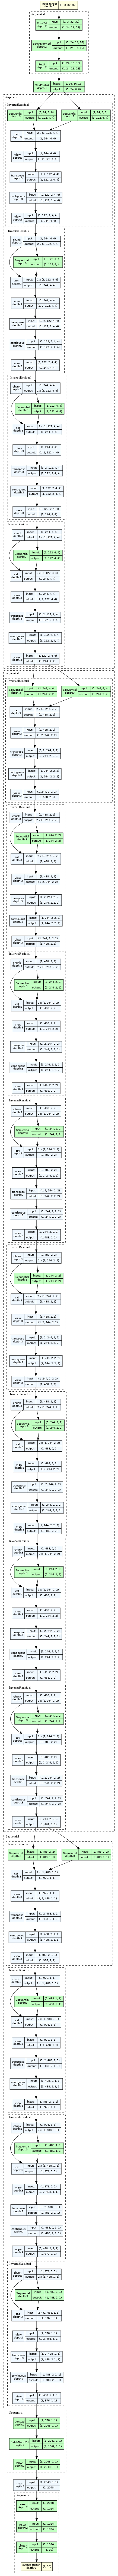

In [55]:
visualize(cnn_model, "ResNet18")

In [42]:
_, resnet_first_acc = simple_work(train_dataset_resnet, test_dataset_resnet, cnn_model)

cuda
TRAIN SECTION


Epoch[1]: Loss = 1.5654, Train accuracy = 0.4607, Time epoch = 27.8642
Epoch[2]: Loss = 0.9121, Train accuracy = 0.6921, Time epoch = 28.0580
Epoch[3]: Loss = 0.7829, Train accuracy = 0.7346, Time epoch = 29.0079
Epoch[4]: Loss = 0.7266, Train accuracy = 0.7526, Time epoch = 28.0648
Epoch[5]: Loss = 0.6938, Train accuracy = 0.7612, Time epoch = 28.3517
Epoch[6]: Loss = 0.6710, Train accuracy = 0.7690, Time epoch = 28.0888
Epoch[7]: Loss = 0.6566, Train accuracy = 0.7741, Time epoch = 28.0690
Epoch[8]: Loss = 0.6420, Train accuracy = 0.7781, Time epoch = 27.8742
Epoch[9]: Loss = 0.6326, Train accuracy = 0.7816, Time epoch = 28.2170
Epoch[10]: Loss = 0.6241, Train accuracy = 0.7856, Time epoch = 28.0702
Total time 281.6740303039551
TEST SECTION
Loss = 0.0013, Test accuracy = 0.7761


2. Два измененных слоя

In [43]:
cnn_model = create_model_second(models.resnet18, models.ResNet18_Weights.DEFAULT)

In [44]:
_, resnet_second_acc = simple_work(train_dataset_resnet, test_dataset_resnet, cnn_model)

cuda
TRAIN SECTION


Epoch[1]: Loss = 1.0816, Train accuracy = 0.6361, Time epoch = 27.6578
Epoch[2]: Loss = 0.6956, Train accuracy = 0.7588, Time epoch = 27.6374
Epoch[3]: Loss = 0.6425, Train accuracy = 0.7763, Time epoch = 27.9496
Epoch[4]: Loss = 0.6240, Train accuracy = 0.7833, Time epoch = 30.2815
Epoch[5]: Loss = 0.6014, Train accuracy = 0.7910, Time epoch = 29.0904
Epoch[6]: Loss = 0.5896, Train accuracy = 0.7956, Time epoch = 29.9241
Epoch[7]: Loss = 0.5731, Train accuracy = 0.8008, Time epoch = 28.9794
Epoch[8]: Loss = 0.5636, Train accuracy = 0.8012, Time epoch = 29.0911
Epoch[9]: Loss = 0.5494, Train accuracy = 0.8106, Time epoch = 30.4523
Epoch[10]: Loss = 0.5355, Train accuracy = 0.8125, Time epoch = 30.2017
Total time 291.27382802963257
TEST SECTION
Loss = 0.0012, Test accuracy = 0.7887


## GoogleNet
1. Один измененный слой

In [45]:
cnn_model = create_model_first(models.googlenet, models.GoogLeNet_Weights.DEFAULT)
train_dataset_gnet, test_dataset_gnet = get_datasets(models.GoogLeNet_Weights.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


Model: GoogleNet
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine

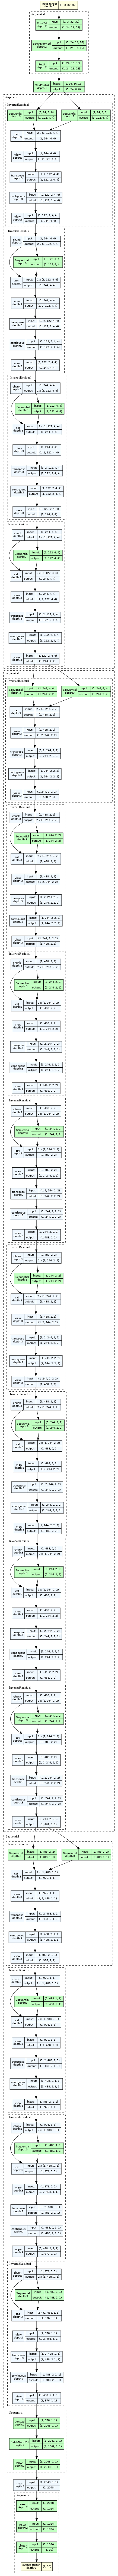

In [56]:
visualize(cnn_model, "GoogleNet")

In [46]:
_, gnet_first_acc = simple_work(train_dataset_gnet, test_dataset_gnet, cnn_model)

cuda
TRAIN SECTION


Epoch[1]: Loss = 1.4771, Train accuracy = 0.5262, Time epoch = 29.2671
Epoch[2]: Loss = 0.9142, Train accuracy = 0.7088, Time epoch = 28.8271
Epoch[3]: Loss = 0.8089, Train accuracy = 0.7343, Time epoch = 29.9921
Epoch[4]: Loss = 0.7557, Train accuracy = 0.7461, Time epoch = 29.6504
Epoch[5]: Loss = 0.7321, Train accuracy = 0.7526, Time epoch = 28.9835
Epoch[6]: Loss = 0.7100, Train accuracy = 0.7591, Time epoch = 29.9469
Epoch[7]: Loss = 0.6971, Train accuracy = 0.7618, Time epoch = 29.4319
Epoch[8]: Loss = 0.6866, Train accuracy = 0.7655, Time epoch = 28.1518
Epoch[9]: Loss = 0.6774, Train accuracy = 0.7684, Time epoch = 30.1918
Epoch[10]: Loss = 0.6680, Train accuracy = 0.7710, Time epoch = 29.2430
Total time 293.6939342021942
TEST SECTION
Loss = 0.0013, Test accuracy = 0.7770


2. Два измененных слоя

In [47]:
cnn_model = create_model_second(models.googlenet, models.GoogLeNet_Weights.DEFAULT)

In [48]:
_, gnet_second_acc = simple_work(train_dataset_gnet, test_dataset_gnet, cnn_model)

cuda
TRAIN SECTION
Epoch[1]: Loss = 0.9970, Train accuracy = 0.6605, Time epoch = 28.2354


Epoch[2]: Loss = 0.7212, Train accuracy = 0.7510, Time epoch = 29.5279
Epoch[3]: Loss = 0.6891, Train accuracy = 0.7596, Time epoch = 27.8897
Epoch[4]: Loss = 0.6688, Train accuracy = 0.7682, Time epoch = 29.5427
Epoch[5]: Loss = 0.6585, Train accuracy = 0.7715, Time epoch = 28.1849
Epoch[6]: Loss = 0.6445, Train accuracy = 0.7757, Time epoch = 29.0558
Epoch[7]: Loss = 0.6325, Train accuracy = 0.7794, Time epoch = 28.0438
Epoch[8]: Loss = 0.6294, Train accuracy = 0.7821, Time epoch = 28.5231
Epoch[9]: Loss = 0.6053, Train accuracy = 0.7894, Time epoch = 29.9251
Epoch[10]: Loss = 0.5936, Train accuracy = 0.7937, Time epoch = 30.0359
Total time 288.974228143692
TEST SECTION
Loss = 0.0012, Test accuracy = 0.7948


## ShuffleNet_V2_X2_0
1. Один измененный слой

In [49]:
cnn_model = create_model_first(models.shufflenet_v2_x2_0, models.ShuffleNet_V2_X2_0_Weights.DEFAULT)
train_dataset_sh, test_dataset_sh = get_datasets(models.ShuffleNet_V2_X2_0_Weights.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


Model: ShuffleNet
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affin

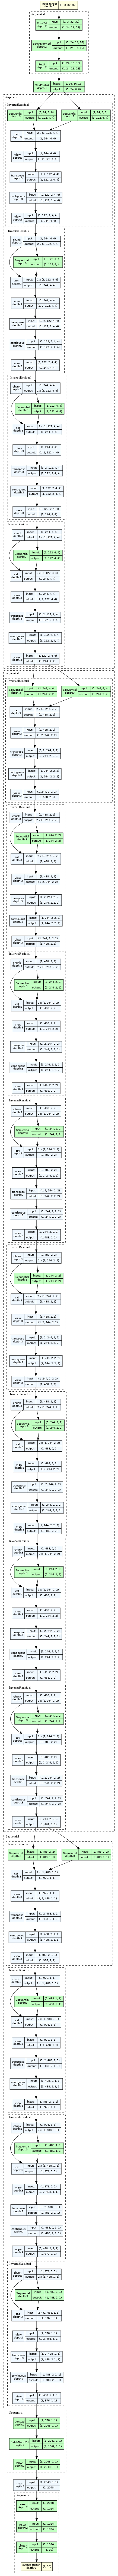

In [57]:
visualize(cnn_model, "ShuffleNet")

In [50]:
_, sh_first_acc = simple_work(train_dataset_sh, test_dataset_sh, cnn_model)

cuda
TRAIN SECTION
Epoch[1]: Loss = 1.0874, Train accuracy = 0.6754, Time epoch = 28.3611


Epoch[2]: Loss = 0.6363, Train accuracy = 0.8037, Time epoch = 29.2412
Epoch[3]: Loss = 0.5457, Train accuracy = 0.8272, Time epoch = 29.2564
Epoch[4]: Loss = 0.4984, Train accuracy = 0.8388, Time epoch = 28.9898
Epoch[5]: Loss = 0.4667, Train accuracy = 0.8482, Time epoch = 28.2906
Epoch[6]: Loss = 0.4411, Train accuracy = 0.8564, Time epoch = 28.9478
Epoch[7]: Loss = 0.4218, Train accuracy = 0.8624, Time epoch = 29.4405
Epoch[8]: Loss = 0.4077, Train accuracy = 0.8654, Time epoch = 29.0441
Epoch[9]: Loss = 0.3956, Train accuracy = 0.8693, Time epoch = 30.3536
Epoch[10]: Loss = 0.3831, Train accuracy = 0.8738, Time epoch = 28.8670
Total time 290.8010687828064
TEST SECTION
Loss = 0.0009, Test accuracy = 0.8522


2. Два измененных слоя

In [51]:
cnn_model = create_model_second(models.shufflenet_v2_x2_0, models.ShuffleNet_V2_X2_0_Weights.DEFAULT)

In [52]:
_, sh_second_acc = simple_work(train_dataset_sh, test_dataset_sh, cnn_model)

cuda
TRAIN SECTION
Epoch[1]: Loss = 0.6218, Train accuracy = 0.7890, Time epoch = 27.3550


Epoch[2]: Loss = 0.4135, Train accuracy = 0.8584, Time epoch = 28.1526
Epoch[3]: Loss = 0.3404, Train accuracy = 0.8825, Time epoch = 27.7320
Epoch[4]: Loss = 0.2880, Train accuracy = 0.9004, Time epoch = 27.3045
Epoch[5]: Loss = 0.2411, Train accuracy = 0.9177, Time epoch = 27.6415
Epoch[6]: Loss = 0.1963, Train accuracy = 0.9348, Time epoch = 28.3932
Epoch[7]: Loss = 0.1558, Train accuracy = 0.9510, Time epoch = 26.9534
Epoch[8]: Loss = 0.1160, Train accuracy = 0.9663, Time epoch = 28.6503
Epoch[9]: Loss = 0.0848, Train accuracy = 0.9774, Time epoch = 28.7943
Epoch[10]: Loss = 0.0599, Train accuracy = 0.9876, Time epoch = 28.2953
Total time 279.2815020084381
TEST SECTION
Loss = 0.0009, Test accuracy = 0.8621


## VIT_B_16
1. Один измененный слой

In [20]:
cnn_model = create_eff_first(models.vit_b_16, models.ViT_B_16_Weights.DEFAULT)
train_dataset_eff, test_dataset_eff = get_datasets(models.ViT_B_16_Weights.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


Model: VIT_B_16
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=

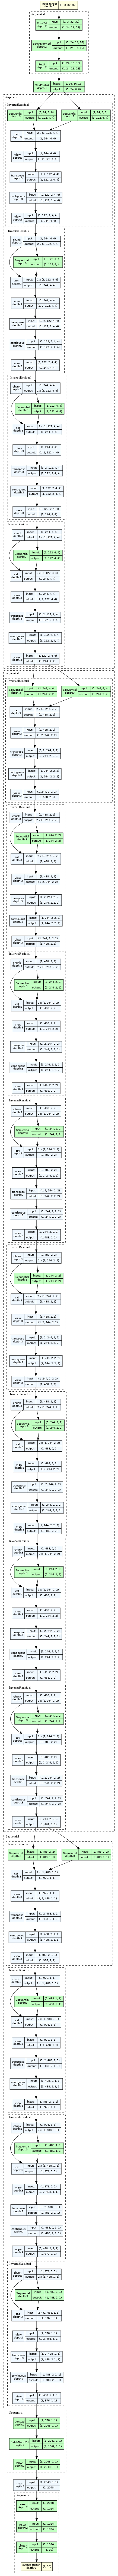

In [58]:
visualize(cnn_model, "VIT_B_16")

In [21]:
_, vit_first_acc = simple_work_eff(train_dataset_eff, test_dataset_eff, cnn_model)

TRAIN SECTION
Epoch[1]: Loss = 0.5765, Train accuracy = 0.8270, Time epoch = 126.9049
Epoch[2]: Loss = 0.2216, Train accuracy = 0.9300, Time epoch = 123.6214
Epoch[3]: Loss = 0.1861, Train accuracy = 0.9400, Time epoch = 138.7737
Epoch[4]: Loss = 0.1674, Train accuracy = 0.9459, Time epoch = 183.8820
Epoch[5]: Loss = 0.1548, Train accuracy = 0.9502, Time epoch = 193.3209
Epoch[6]: Loss = 0.1460, Train accuracy = 0.9528, Time epoch = 256.4761
Epoch[7]: Loss = 0.1385, Train accuracy = 0.9560, Time epoch = 249.6771
Epoch[8]: Loss = 0.1330, Train accuracy = 0.9570, Time epoch = 256.3847
Epoch[9]: Loss = 0.1277, Train accuracy = 0.9587, Time epoch = 254.8293
Epoch[10]: Loss = 0.1237, Train accuracy = 0.9602, Time epoch = 258.4572
Total time 2042.339988708496
TEST SECTION
Loss = 0.0003, Test accuracy = 0.9465


2. Два измененных слоя

In [23]:
cnn_model = create_eff_second(models.vit_b_16, models.ViT_B_16_Weights.DEFAULT)

In [24]:
_, vit_second_acc = simple_work_eff(train_dataset_eff, test_dataset_eff, cnn_model)

TRAIN SECTION


Epoch[1]: Loss = 0.2636, Train accuracy = 0.9158, Time epoch = 124.0035
Epoch[2]: Loss = 0.1290, Train accuracy = 0.9569, Time epoch = 123.4478
Epoch[3]: Loss = 0.1004, Train accuracy = 0.9662, Time epoch = 123.7221
Epoch[4]: Loss = 0.0790, Train accuracy = 0.9744, Time epoch = 123.8160
Epoch[5]: Loss = 0.0609, Train accuracy = 0.9810, Time epoch = 124.4330
Epoch[6]: Loss = 0.0476, Train accuracy = 0.9865, Time epoch = 123.8866
Epoch[7]: Loss = 0.0345, Train accuracy = 0.9915, Time epoch = 123.9231
Epoch[8]: Loss = 0.0243, Train accuracy = 0.9954, Time epoch = 124.3257
Epoch[9]: Loss = 0.0177, Train accuracy = 0.9974, Time epoch = 123.8773
Epoch[10]: Loss = 0.0125, Train accuracy = 0.9986, Time epoch = 123.7938
Total time 1239.238777399063
TEST SECTION
Loss = 0.0003, Test accuracy = 0.9544


Гистограмма

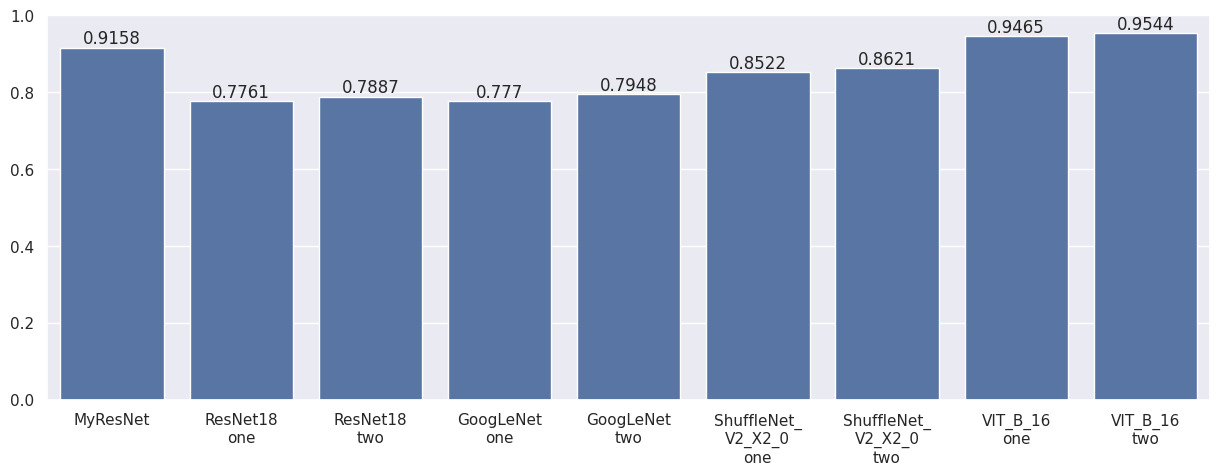

In [54]:
for_gist = {
    "MyResNet": 0.9158,
    "ResNet18\none": resnet_first_acc.item(),
    "ResNet18\ntwo": resnet_second_acc.item(),
    "GoogLeNet\none": gnet_first_acc.item(),
    "GoogLeNet\ntwo": gnet_second_acc.item(),
    "ShuffleNet_\nV2_X2_0\none": sh_first_acc.item(),
    "ShuffleNet_\nV2_X2_0\ntwo": sh_second_acc.item(),
    "VIT_B_16\none": vit_first_acc.item(),
    "VIT_B_16\ntwo": vit_second_acc.item(),
}

seaborn.set(rc={'figure.figsize': (15, 5)})

ax = seaborn.barplot(x=list(for_gist.keys()), y=list(for_gist.values()))

for i in ax.containers:
    ax.bar_label(i,)